In [1]:
import os
import glob
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from torch.autograd import Function
from torchvision.datasets import ImageFolder
from tensorboardX import SummaryWriter
from qqdm.notebook import qqdm
import csv
from PIL import Image
from sklearn.manifold import TSNE

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 4"

/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Download dataset
ckpt_path = "./DANN_svhn/ckpts"
os.makedirs(ckpt_path, exist_ok=True)

mnist_data = "/data/dlcv/hw2/hw2_data/digits/mnistm/data"
mnist_label = "/data/dlcv/hw2/hw2_data/digits/mnistm/train.csv"
mnist_valid = "/data/dlcv/hw2/hw2_data/digits/mnistm/val.csv"
svhn_data = "/data/dlcv/hw2/hw2_data/digits/svhn/data"
svhn_label = "/data/dlcv/hw2/hw2_data/digits/svhn/train.csv"
svhn_valid = "/data/dlcv/hw2/hw2_data/digits/svhn/val.csv"

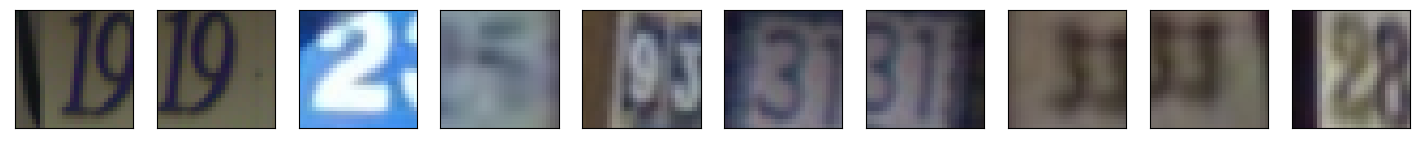

In [3]:
def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(os.path.join(svhn_data, f'{i+0:05d}.png')))

In [4]:
csv = pd.read_csv(svhn_label)
labels = [(name, label) for (name, label) in zip(csv['image_name'], csv['label'])]
# labels = [ label for label in csv['label']]
csv.head(3)
print(labels[-3:-1])

# label path -> .csv
# input path -> data

[('79428.png', 7), ('79429.png', 6)]


In [5]:
class digitsDataset(Dataset):
    def __init__(self, inputPath, labelPath, resize=28):
        self.inputPath = inputPath
        self.transform = transforms.Compose([
            transforms.Resize((resize,resize)),
            # transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
        self.norm = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
            transforms.RandomRotation(15)
            # transforms.Normalize(mean=(0.44, 0.44, 0.44), std=(0.19, 0.19, 0.19))
        ])
        self.pd = pd.read_csv(labelPath)
        self.csv = [(name, label) for (name, label) in zip(self.pd['image_name'], self.pd['label'])]
        
    def __getitem__(self, index):
        inputImage = Image.open(os.path.join(self.inputPath, self.csv[index][0]))
        label = int(self.csv[index][1])
        inputImage = self.transform(inputImage)
        inputImage = inputImage.expand(3, inputImage.data.shape[1], inputImage.data.shape[2])
        inputImage = self.norm(inputImage)
        
        return inputImage, label        
        
    def __len__(self):
        return len(self.csv)

In [6]:
mnistDataset = digitsDataset(mnist_data, mnist_label)
mnistValDataset = digitsDataset(mnist_data, mnist_valid)
svhnDataset = digitsDataset(svhn_data, svhn_label)
svhnValDataset = digitsDataset(svhn_data, svhn_valid)

print('# images in mnist train:', len(mnistDataset))
print('# images in usps train:', len(svhnDataset))
print('# images in usps valid:', len(svhnValDataset))
    
mnist_train_loader = DataLoader(dataset=mnistDataset, batch_size=32, shuffle=True, num_workers=4)
mnist_valid_loader = DataLoader(dataset=mnistValDataset, batch_size=4, shuffle=False, num_workers=0)
svhn_train_loader = DataLoader(dataset=svhnDataset, batch_size=32, shuffle=True, num_workers=4)
svhn_val_loader = DataLoader(dataset=svhnValDataset, batch_size=4, shuffle=False, num_workers=0)

dataiter = iter(mnist_valid_loader)
images, labels = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device used:', device)

# images in mnist train: 44800
# images in usps train: 63544
# images in usps valid: 15887
Image tensor in each batch: torch.Size([4, 3, 28, 28]) torch.float32
Label tensor in each batch: torch.Size([4]) torch.int64
Device used: cuda


Labels:
tensor(5) tensor(0) tensor(9)


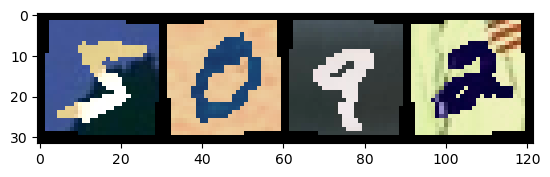

In [7]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:')
print(' '.join('%5s' % labels[j] for j in range(3)))

# Model


In [8]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # nn.MaxPool2d(2)
        ) 
    def forward(self, x):
        # print("QQQQ= ", x.shape)
        x = self.conv(x).squeeze()
        # print("QAQ = ", x.shape)
        return x.flatten(1)

class LabelPredictor(nn.Module):
    def __init__(self):
        super(LabelPredictor, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
    def forward(self, h):
        y = self.layer(h)
        return y

In [10]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()
print(feature_extractor)
print(label_predictor)
print(domain_classifier)

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# Use GPU if available, otherwise stick with cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device used:', device)

FeatureExtractor(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 512, kernel_size=(3, 3)

In [26]:
from torchsummary import summary
summary(feature_extractor, (3, 28, 28), 3)
# summary(domain_classifier, (512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [3, 64, 28, 28]           1,792
       BatchNorm2d-2            [3, 64, 28, 28]             128
              ReLU-3            [3, 64, 28, 28]               0
         MaxPool2d-4            [3, 64, 14, 14]               0
            Conv2d-5           [3, 128, 14, 14]          73,856
       BatchNorm2d-6           [3, 128, 14, 14]             256
              ReLU-7           [3, 128, 14, 14]               0
         MaxPool2d-8             [3, 128, 7, 7]               0
            Conv2d-9             [3, 256, 5, 5]         295,168
      BatchNorm2d-10             [3, 256, 5, 5]             512
             ReLU-11             [3, 256, 5, 5]               0
           Conv2d-12             [3, 256, 3, 3]         590,080
      BatchNorm2d-13             [3, 256, 3, 3]             512
             ReLU-14             [3, 25

In [10]:
def train_epoch(mnist_train_loader, svhn_train_loader, svhn_val_loader, lamb):
    best_acc = 0
    for epoch in range(500):
        running_D_loss, running_F_loss = 0.0, 0.0
        mnist_acc = 0
        feature_extractor.train()
        label_predictor.train()
        domain_classifier.train()
        
        for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(mnist_train_loader, svhn_train_loader)):
            source_data = source_data.cuda()
            source_label = source_label.cuda()
            target_data = target_data.cuda()
            
            mixed_data = torch.cat([source_data, target_data], dim=0)
            domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
            domain_label[:source_data.shape[0]] = 1

            # Step 1 : train domain classifier
            feature = feature_extractor(mixed_data)
            domain_logits = domain_classifier(feature.detach())
            loss = domain_criterion(domain_logits, domain_label)
            running_D_loss+= loss.item()
            optimizer_D.zero_grad()
            loss.backward()
            optimizer_D.step()

            # Step 2 : train feature extractor and label classifier
            class_logits = label_predictor(feature[:source_data.shape[0]])
            mnist_acc += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
            
            domain_logits = domain_classifier(feature)
            loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
            running_F_loss+= loss.item() 
            optimizer_F.zero_grad()
            optimizer_C.zero_grad()
            loss.backward()
            optimizer_F.step()
            optimizer_C.step()
            print(i, end='\r')
            
        mnist_acc /= min(len(mnist_train_loader.dataset), len(svhn_train_loader.dataset))    
        with torch.no_grad():
            feature_extractor.eval()
            label_predictor.eval()
            acc = 0
            val_loss = 0
            for i , (val_data, val_label) in enumerate(svhn_val_loader):
                val_data, val_label = val_data.cuda(), val_label.cuda()  
                pred = label_predictor(feature_extractor(val_data))
                acc += torch.sum(torch.argmax(pred, dim=1) == val_label).item()
                val_loss += class_criterion(pred, val_label).item()              
                print(i, end='\r')
            acc /= len(svhn_val_loader.dataset)
        print("epoch: {:3d}, Dloss: {:6.4f}, Floss: {:6.4f}, val_loss: {:6.4f}, mnist_acc: {:6.4f}, usps_acc: {:6.4f}, best_acc:{:6.4f}".format(epoch+1, running_D_loss/(epoch+1), running_F_loss/(epoch+1), val_loss/(epoch+1), mnist_acc, acc, best_acc))
        
        if acc > best_acc:
            torch.save(feature_extractor.state_dict(), os.path.join(ckpt_path, f'extractor_.pth'))
            torch.save(label_predictor.state_dict(), os.path.join(ckpt_path, f'predictor_.pth'))
            best_acc = acc
            print(f' | Save checkpoint to epoch{epoch+1}.')
    
train_epoch(mnist_train_loader, svhn_train_loader, svhn_val_loader, lamb=0.2)


epoch:   1, Dloss: 550.9281, Floss: 479.9260, val_loss: 11540.6155, mnist_acc: 0.8692, usps_acc: 0.3908, best_acc:0.0000
 | Save checkpoint to epoch1.
epoch:   2, Dloss: 288.3165, Floss: 80.2251, val_loss: 9401.9918, mnist_acc: 0.9405, usps_acc: 0.3855, best_acc:0.3908
epoch:   3, Dloss: 202.0878, Floss: 33.0600, val_loss: 4758.8977, mnist_acc: 0.9534, usps_acc: 0.3739, best_acc:0.3908
epoch:   4, Dloss: 154.8887, Floss: 15.5529, val_loss: 5571.5769, mnist_acc: 0.9609, usps_acc: 0.3833, best_acc:0.3908
epoch:   5, Dloss: 125.7235, Floss: 7.0193, val_loss: 3550.0996, mnist_acc: 0.9662, usps_acc: 0.4156, best_acc:0.3908
 | Save checkpoint to epoch5.
epoch:   6, Dloss: 105.7412, Floss: 3.0539, val_loss: 2773.2979, mnist_acc: 0.9684, usps_acc: 0.4379, best_acc:0.4156
 | Save checkpoint to epoch6.
epoch:   7, Dloss: 93.6542, Floss: 0.0857, val_loss: 2351.8192, mnist_acc: 0.9721, usps_acc: 0.4315, best_acc:0.4379
epoch:   8, Dloss: 82.9094, Floss: -1.5321, val_loss: 2223.3316, mnist_acc: 0.9

KeyboardInterrupt: 

In [9]:
# Lower bound: train on source, evaluate on target
# def train_lowerbound(mnist_train_loader, svhn_val_loader):

for epoch in range(10):
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    feature_extractor.train()
    label_predictor.train()
    for i, (source_data, source_label) in enumerate(mnist_train_loader):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        feature = feature_extractor(source_data)
        
        class_logits = label_predictor(feature)
        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label)
        running_F_loss+= loss.item()
        
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()            

    with torch.no_grad():
        feature_extractor.eval()
        label_predictor.eval()
        acc = 0.0
        val_loss = 0.0
        for i , (val_data, val_label) in enumerate(svhn_val_loader):
            val_data, val_label = val_data.cuda(), val_label.cuda()                
            class_logits = label_predictor(feature_extractor(val_data))
            val_loss += class_criterion(class_logits, val_label).item()                
            acc += torch.sum(torch.argmax(class_logits, dim=1) == val_label).item()
    print("epoch: {:2d}, Floss: {:6.4f}, val_loss: {:6.4f}, mnist_hit: {}, mnist_acc: {:6.4f}, svhn hit: {}, svhn acc: {:6.4f}".format(epoch+1, running_F_loss, val_loss, total_hit, total_hit/total_num, acc, acc/len(svhn_val_loader.dataset)))

# train_lowerbound(mnist_train_loader, svhn_val_loader)

epoch:  1, Floss: 568.5769, val_loss: 8211.6943, mnist_hit: 39091.0, mnist_acc: 0.8726, svhn hit: 5348.0, svhn acc: 0.3366
epoch:  2, Floss: 270.8979, val_loss: 8081.7242, mnist_hit: 42220.0, mnist_acc: 0.9424, svhn hit: 5076.0, svhn acc: 0.3195
epoch:  3, Floss: 208.6319, val_loss: 9377.2505, mnist_hit: 42801.0, mnist_acc: 0.9554, svhn hit: 4597.0, svhn acc: 0.2894
epoch:  4, Floss: 179.1079, val_loss: 9971.0380, mnist_hit: 43060.0, mnist_acc: 0.9612, svhn hit: 4346.0, svhn acc: 0.2736
epoch:  5, Floss: 154.9922, val_loss: 7985.4513, mnist_hit: 43287.0, mnist_acc: 0.9662, svhn hit: 5612.0, svhn acc: 0.3532
epoch:  6, Floss: 137.7770, val_loss: 10643.1124, mnist_hit: 43417.0, mnist_acc: 0.9691, svhn hit: 4465.0, svhn acc: 0.2810
epoch:  7, Floss: 124.4605, val_loss: 8190.9434, mnist_hit: 43541.0, mnist_acc: 0.9719, svhn hit: 5282.0, svhn acc: 0.3325
epoch:  8, Floss: 105.8182, val_loss: 9086.9566, mnist_hit: 43686.0, mnist_acc: 0.9751, svhn hit: 4881.0, svhn acc: 0.3072
epoch:  9, Flos

In [10]:
# Upper bound: train on target, evaluate on target
# def train_upperbound(svhn_train_loader, svhn_val_loader):

for epoch in range(10):
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    feature_extractor.train()
    label_predictor.train()
    for i, (source_data, source_label) in enumerate(svhn_train_loader):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        feature = feature_extractor(source_data)
        
        class_logits = label_predictor(feature)
        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        loss = class_criterion(class_logits, source_label)
        running_F_loss+= loss.item()
        
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()      
        
    with torch.no_grad():
        feature_extractor.eval()
        label_predictor.eval()
        acc = 0.0
        val_loss = 0.0
        for i , (val_data, val_label) in enumerate(svhn_val_loader):
            val_data, val_label = val_data.cuda(), val_label.cuda()                
            class_logits = label_predictor(feature_extractor(val_data))
            val_loss += class_criterion(class_logits, val_label).item()                
            acc += torch.sum(torch.argmax(class_logits, dim=1) == val_label).item()
    print("epoch: {:2d}, Floss: {:6.4f}, val_loss: {:6.4f}, mnist_hit: {}, mnist_acc: {:6.4f}, svhn hit: {}, svhn acc: {:6.4f}".format(epoch+1, running_F_loss, val_loss, total_hit, total_hit/total_num, acc, acc/len(svhn_val_loader.dataset)))

# train_upperbound(svhn_train_loader, svhn_val_loader)

epoch:  1, Floss: 1157.0766, val_loss: 1681.9920, mnist_hit: 52296.0, mnist_acc: 0.8230, svhn hit: 13830.0, svhn acc: 0.8705
epoch:  2, Floss: 727.9552, val_loss: 1422.5568, mnist_hit: 56478.0, mnist_acc: 0.8888, svhn hit: 14241.0, svhn acc: 0.8964
epoch:  3, Floss: 611.1887, val_loss: 1259.0536, mnist_hit: 57608.0, mnist_acc: 0.9066, svhn hit: 14372.0, svhn acc: 0.9046
epoch:  4, Floss: 536.9083, val_loss: 1190.9235, mnist_hit: 58345.0, mnist_acc: 0.9182, svhn hit: 14500.0, svhn acc: 0.9127
epoch:  5, Floss: 478.7287, val_loss: 1189.3769, mnist_hit: 58952.0, mnist_acc: 0.9277, svhn hit: 14537.0, svhn acc: 0.9150
epoch:  6, Floss: 442.5766, val_loss: 1139.0488, mnist_hit: 59259.0, mnist_acc: 0.9326, svhn hit: 14618.0, svhn acc: 0.9201
epoch:  7, Floss: 398.4137, val_loss: 1142.9878, mnist_hit: 59711.0, mnist_acc: 0.9397, svhn hit: 14594.0, svhn acc: 0.9186
epoch:  8, Floss: 370.4689, val_loss: 1149.7154, mnist_hit: 59989.0, mnist_acc: 0.9441, svhn hit: 14640.0, svhn acc: 0.9215
epoch: 

| Calaculate accuracy ... 
hit: 7744, len: 15887, acc: 0.4874425631019072
| TSNE ... 


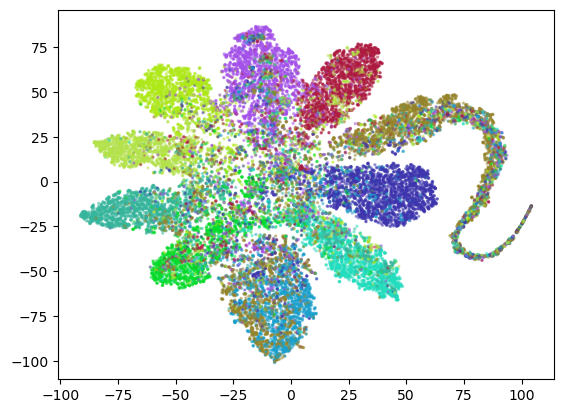

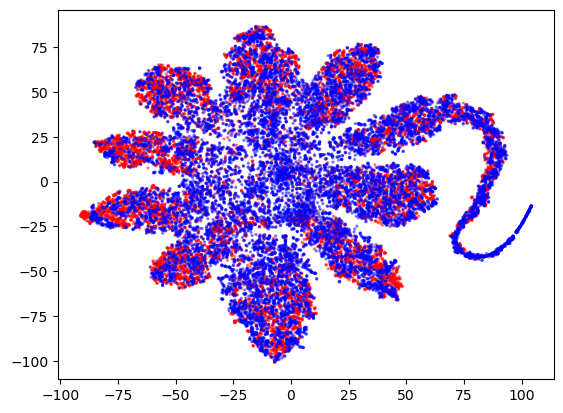

In [13]:
label_pred = LabelPredictor().cuda()
opt_C = optim.Adam(label_pred.parameters())
feat_extr = FeatureExtractor().cuda()
opt_F = optim.Adam(feat_extr.parameters())

label_pred.load_state_dict(torch.load('./svhn_predictor.pth'))
feat_extr.load_state_dict(torch.load('./svhn_extractor.pth'))
label_pred.eval()
feat_extr.eval()

total_hit = 0
total_num = 0
val_loss = 0
# Accuracy
print('| Calaculate accuracy ... ')
for i, (val_data, val_label) in enumerate(svhn_val_loader):
    val_data = val_data.cuda()
    val_label = val_label.cuda()

    class_logits = label_pred(feat_extr(val_data))
    val_loss += class_criterion(class_logits, val_label).item()
    
    total_hit += torch.sum(torch.argmax(class_logits, dim=1) == val_label).item()
    total_num += val_data.shape[0]
    
print("hit: {}, len: {}, acc: {}".format(total_hit, total_num, total_hit/total_num))

print("| TSNE ... ")
colors = np.random.random((10, 3))
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
with torch.no_grad():
    outputs, labels, domains = [], [], []
    result = []
    total_hit = 0
    total_num = 0
    val_loss = 0
    for i, (val_data, val_label) in enumerate(mnist_valid_loader):
        val_data = val_data.cuda()
        feature = feat_extr(val_data)
        outputs.append(feature.cpu().numpy())
        labels.append(val_label)
        domains.append(np.ones(val_data.shape[0], dtype=np.int8))
        
    for i, (val_data, val_label) in enumerate(svhn_val_loader):
        val_data = val_data.cuda()
        feature = feat_extr(val_data)
        outputs.append(feature.cpu().numpy())
        labels.append(val_label)
        domains.append(np.zeros(val_data.shape[0], dtype=np.int8))

    outputs = np.concatenate(outputs, axis=0)
    labels = np.concatenate(labels, axis=0)
    domains = np.concatenate(domains, axis=0)
    tsne_proj = tsne.fit_transform(outputs)
    plt1, plt2 = plt.figure(1), plt.figure(2)
    ax1, ax2 = plt1.add_subplot(111), plt2.add_subplot(111)
    ax1.scatter(tsne_proj[:,0], tsne_proj[:,1], s=2, color=[tuple(colors[i]) for i in labels], alpha=0.4)
    ax2.scatter(tsne_proj[:,0], tsne_proj[:,1], s=2, color=['r' if i == 1 else 'b' for i in domains], alpha=0.4)
    plt.show()

In [11]:
label_pred = LabelPredictor().cuda()
opt_C = optim.Adam(label_pred.parameters())
feat_extr = FeatureExtractor().cuda()
opt_F = optim.Adam(feat_extr.parameters())

label_pred.load_state_dict(torch.load(os.path.join(ckpt_path, 'svhn_predictor.pth')))
feat_extr.load_state_dict(torch.load(os.path.join(ckpt_path, 'svhn_extractor.pth')))
label_pred.eval()
feat_extr.eval()

total_hit = 0
total_num = 0
val_loss = 0
# Accuracy
print('| Calaculate accuracy ... ')
for i, (val_data, val_label) in enumerate(svhn_val_loader):
    val_data = val_data.cuda()
    val_label = val_label.cuda()
    class_logits = label_pred(feat_extr(val_data))
    val_loss += class_criterion(class_logits, val_label).item()
    
    total_hit += torch.sum(torch.argmax(class_logits, dim=1) == val_label).item()
    total_num += val_data.shape[0]
    
print("hit: {}, len: {}, acc: {}".format(total_hit, total_num, total_hit/total_num))


| Calaculate accuracy ... 
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
torch.Size([4, 3, 28, 28])
t

KeyboardInterrupt: 

# Inference

就跟前幾次作業一樣。這裡我使用pd來生產csv，因為看起來比較潮(?)

此外，200 epochs的Accuracy可能會不太穩定，可以多丟幾次或train久一點。

In [116]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(loaderTargetVal):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

有任何問題 Domain Adaptation 的問題可以寄信到ntu-ml-2021spring-ta@googlegroups.com。

時間允許的話我會更新在這裡。

# Special Thanks
這次的作業其實是我出在 2019FALL 的 ML Final Project，以下是我認為在 Final Report 不錯的幾組，有興趣的話歡迎大家參考看看。

[NTU_r08942071_太神啦 / 組長: 劉正仁同學](https://drive.google.com/open?id=11uNDcz7_eMS8dMQxvnWsbrdguu9k4c-c)

[NTU_r08921a08_CAT / 組長: 廖子毅同學](https://drive.google.com/open?id=1xIkSs8HAShdcfV1E0NEnf4JDbL7POZTf)
